# Groover Technical test

This notebook presents the results obtained in the context of the Groover data science internship test by Julien Guinot. Part 1 is a summarization of a research paper which can be found in pdf file in the directory in which this notebook was sent

## Part 2

In part 2, we are provided with 19 raw WAV files containing samples of music from the Groover library. All samples are 30s long, though not exactly of the same size. For image feature extraction such as spectrograms, we will have to apply padding to the images to attain fixed-length input . Our goal is to extract audio features to be later used for a given machine learning task.

That being said, we are looking to extract audio features which are crucial for classification tasks or recommendation tasks. many common audio features exist, including but not limited to:

- Mel frequency cepstral coefficients, a representation of the spectral envelope of an audio signal
- Tempo, which is crucial to genre classification
- Spectrogram
- Spectral Centroid
- Zero crossing rate
- Spectral bandwidth
- Total harmonic distortion
- etc.

We will be building a dataset comprised of audio features for both song level and beat level features. This means we will compute the features for each song (30s clip), attribute a tempo to the song and split the signal according to this evaluated tempo, and re-compute the features for each beat split from the original signal. This will provide a global feature value for each clip and also allow us to look into more detail, which will be useful for tasks such as chorus loudness analysis when compared to the verse.

All this can be achieved using the Librosa library, which is particularly adapted for audio signal feature extraction tasks.

## Part 3

For part 3, we are provided with a pre-constructed dataset of audio features for 1000 fixed length songs. the goal here is to build a genre classification model based on the provided features with respect to the single-label ground truth column  in the dataset, which will be explored later. To do this, we will:

- Have a preliminary section of exploratory data analysis on the features of the provided dataset # almost done
- Consider relevant features and/or feature engineering opportunities 
- Conduct pre-processing, including but not limited to : cleaning the data, scaling the data, augmenting the data # almost done
- Split the data into training, test, and validation data (consider K-fold validation for optimal model selection) # almost done
- establish relevant training metrics for multi-class classification problem) # almost done
- Establish a baseline using common out-of-the-box classification models (logistic regression, naive bayes, random forest, MLP...) # almost done
- Select a few models to fine-tune
- Conduct a grid search for optimal hyperparameters on the selected model
- Compare our final most relevant model's results with the others and perhaps with state of the art models





## Basic imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import torch
import keras
import sklearn
import librosa
from src.Audio_proc_utils import AudioFeatureExtractor
from src.Preproc_utils import train_test_val_split
from src.Training_utils import plot_learning_curve
from sklearn.model_selection import GridSearchCV
from src.Evaluation_utils import score_classifier, plot_confusion_matrix,microscore_classifier
import time

t0 = time.time()

sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

C:\Users\Administrator_juj\anaconda3\envs\Groovrtest\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Part 2

As previously stated, the goal of this section is to extract audio features from the 20 audio files provided as raw data. Many available audio features are available to be extracted and useful for audio tasks, but we focus on a few criteria:

- having a mix of high, mid and low level features. high-level features can be understood by humans: key, timbre, rythm. Mid-level features are agregated of low-level features than can be felt but not quantified by human ears (MFCC coefficients, dynamic range...). Low-level features mean nothing for humans but can be interpreted by a machine learning algorithm (RMS, Spectral Centroid...)

- Extracting a large amount of features to allow for down the road feature engineering and wealth of choice for any possible task

- Save on computation power : If a feature needs to be extracted by means of a costly ML algorithm, we choose to drop it.

This being said, we choose to focus on the following features:

#### High-level 

- Tempo
- Duration
- Key

#### Mid-level

- MFCC coefficients mean and std
- Dynamic range
- transient strength
- Band energy ratio
- Amplitude envelope mean
- harmonic to percussive ratio

#### Low-Level

- RMS mean and standard deviation
- Spectral centroid, contrast, rolloff, bandwidth mean and standard deviation
- harmonic and percussive elements RMS mean
- Zero crossing rate 
- Chroma STFT and CENS mean and standard deviation
- Spectrogram, Mel-Spectrogram, Chromagram

*The code containing all of the processing steps can be found at the following github repo in src/Audio_proc_utils.py*

https://github.com/Pliploop/Groover_Tech_Test

In [2]:

extractor = AudioFeatureExtractor()
generate = False
if generate:
    dataset_extracted = extractor.build_30s_dataset()
    big_dataset = extractor.build_sub_datasets(path=None)
else:
    dataset_extracted = pd.read_csv('./data/unsplit.csv')
    big_dataset = pd.read_csv('./data/split.csv')

In [3]:
try:
    display(dataset_extracted.head())
except:
    pass

filename                                  uuid   duration  \
0   music0  af918a47-02af-4064-ac69-c46732d17496  30.013333   
1   music1  50215fcf-3c51-4eeb-9514-d7909dee4508  30.013333   
2  music10  55f537a2-d9b3-40f5-90b0-f68cfc052e4c  30.013333   
3  music11  c345b5f7-8d0d-4155-8984-c9d1c74da654  30.013333   
4  music12  f4f621dc-46b8-4d26-b301-d3607d4dee58  30.013333   

   zero_crossing_rate       tempo  dynamic_range  rms_mean   rms_std  \
0            0.051973   83.354335      31.631625  0.077110  0.077108   
1            0.092525  135.999178       6.089439  0.136321  0.021771   
2            0.120721  123.046875      12.423949  0.116129  0.059247   
3            0.173752  123.046875      21.266725  0.115771  0.050087   
4            0.075397   99.384014      56.016366  0.173576  0.079108   

   harmonic_rms  percussive_rms  ...  mfcc_15_mean  mfcc_15_std  mfcc_16_mean  \
0      0.059471        0.026265  ...      3.292786    10.795691     -4.524483   
1      0.100224        0.051450  ...     12.336756     7.828080      0.020517   
2      0.059280        0.070543  ...     -5.582714     6.578036     -4.691309   
3      0.072093        0.057329  ...     -1.191364     6.848310     -4.374083   
4      0.105975        0.087093  ...      2.990675     7.298775     -4.508061   

   mfcc_16_std  mfcc_17_mean  mfcc_17_std  mfcc_18_mean  mfcc_18_std  \
0    11.753172      0.496720    10.288208      5.921975    11.868930   
1     8.563534     -0.743094     7.499599     -5.130959     9.796183   
2     5.473560     -2.714943     6.238592     -1.851295     7.699596   
3     6.227931     -3.646294     7.037104     -2.083611     7.434423   
4     7.767137      4.687869     7.235426     -4.113947     7.940424   

   mfcc_19_mean  mfcc_19_std  
0      3.214540    13.041427  
1      3.297938     9.621299  
2     -3.103203     5.479458  
3     -0.307833     7.560038  
4     -2.781825     7.834619  

[5 rows x 65 columns]

In [4]:
try:
    display(big_dataset.head())
except:
    pass

Unnamed: 0                              filename  \
0           0  af918a47-02af-4064-ac69-c46732d17496   
1           1  af918a47-02af-4064-ac69-c46732d17496   
2           2  af918a47-02af-4064-ac69-c46732d17496   
3           3  af918a47-02af-4064-ac69-c46732d17496   
4           4  af918a47-02af-4064-ac69-c46732d17496   

                                     uuid  duration  zero_crossing_rate  \
0  af918a47-02af-4064-ac69-c46732d17496_0  2.878957            0.028466   
1  af918a47-02af-4064-ac69-c46732d17496_1  2.879002            0.061535   
2  af918a47-02af-4064-ac69-c46732d17496_2  2.879002            0.056530   
3  af918a47-02af-4064-ac69-c46732d17496_3  2.879002            0.047076   
4  af918a47-02af-4064-ac69-c46732d17496_4  2.879002            0.050663   

        tempo  dynamic_range   rms_mean    rms_std  harmonic_rms  ...  \
0   83.354335      17.183074  2158.0500  1562.0201     1803.0055  ...   
1  143.554688      18.697077  2373.0906  1724.2886     1472.0734  ...   
2  135.999178      17.359577  2136.1113  1006.4588     1657.3612  ...   
3  135.999178      16.717283  1921.1050   929.4117     1607.6128  ...   
4   83.354335      19.675057  1776.0513  1187.2065     1292.3860  ...   

   mfcc_15_mean  mfcc_15_std  mfcc_16_mean  mfcc_16_std  mfcc_17_mean  \
0     -3.831833     5.389749     -8.219370     5.732867     -4.049472   
1     -4.162188     6.839745     -7.420382     9.559020     -0.685337   
2     -3.180138     7.758219    -10.483070     7.463266     -5.715589   
3      7.815577     8.743066     -1.907271     8.322871     -2.857981   
4     10.070464    10.042364     -2.281360     8.712293     -4.714451   

   mfcc_17_std  mfcc_18_mean  mfcc_18_std  mfcc_19_mean  mfcc_19_std  
0     6.259430      2.712232     4.955466      5.454936     7.362263  
1    12.457345      4.177650    15.372591      4.027757    14.251276  
2     5.069893      5.752574     8.815529      9.280833    15.673746  
3     6.901918      3.241719     6.190395     -6.303412     8.606876  
4     6.393735     -3.316139     6.468756     -1.392479    10.432495  

[5 rows x 66 columns]

Our data was successfully extracted through the build pipeline. It would have been appreciable to conduct exploratory data analysis of the results. Unfortunately with 20 samples and the alloted time frame, this was not possible over the course of this study.

#### To-do

- Possible high-level additions:
    - Key detection ( https://github.com/jackmcarthur/musical-key-finder )
    - Transient strength (onset strength)
    - amplitude envelope
    - Band energy ratio

## Part 3

In [5]:
dataset = pd.read_csv('data/part3_GrooverChallengeDataset.csv')

In [6]:
dataset.head()

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0  661794          0.350088         0.088757  0.130228  0.002827   
1  661794          0.340914         0.094980  0.095948  0.002373   
2  661794          0.363637         0.085275  0.175570  0.002746   
3  661794          0.404785         0.093999  0.141093  0.006346   
4  661794          0.308526         0.087841  0.091529  0.002303   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1784.165850          129774.064525              2002.449060   
1             1530.176679          375850.073649              2039.036516   
2             1552.811865          156467.643368              1747.702312   
3             1070.106615          184355.942417              1596.412872   
4             1835.004266          343399.939274              1748.172116   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_var  mfcc17_mean  \
0            85882.761315   3805.839606  ...   52.420910    -1.690215   
1           213843.755497   3550.522098  ...   55.356403    -0.731125   
2            76254.192257   3042.260232  ...   40.598766    -7.729093   
3           166441.494769   2184.745799  ...   44.427753    -3.319597   
4            88445.209036   3579.757627  ...   86.099236    -5.454034   

   mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  mfcc20_mean  \
0   36.524071    -0.408979   41.597103    -2.303523   55.062923     1.221291   
1   60.314529     0.295073   48.120598    -0.283518   51.106190     0.531217   
2   47.639427    -1.816407   52.382141    -3.439720   46.639660    -2.231258   
3   50.206673     0.636965   37.319130    -0.619121   37.259739    -3.407448   
4   75.269707    -0.916874   53.613918    -4.404827   62.910812   -11.703234   

   mfcc20_var  label  
0   46.936035  blues  
1   45.786282  blues  
2   30.573025  blues  
3   31.949339  blues  
4   55.195160  blues  

[5 rows x 59 columns]

In [7]:
dataset.columns

Index(['length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
       'label'

In [8]:
dataset.label.unique()

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

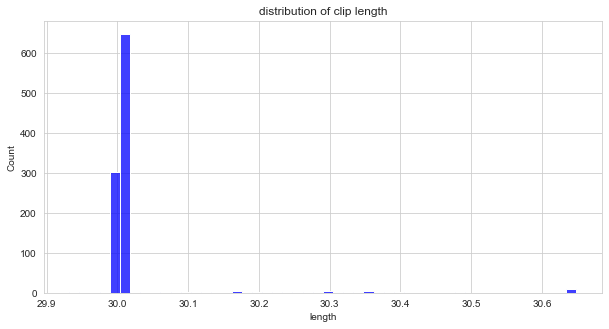

In [9]:
fig,ax = plt.subplots(figsize=(10,5))
sns.histplot(dataset.length/22050,bins=50,color='b')
plt.title('distribution of clip length')
display()

In [10]:
dataset[dataset.isnull()].count().sum()

0

The dataset has no missing values, which leads us to believe that it does not have to be cleaned.

In [11]:
dataset.groupby('label').count().length

label
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: length, dtype: int64

Furthermore, the classes are already balanced, which greatly facilitates the task for classification, but does not truly represent the data we would get from real-life data scrapping and genre distribution in popular music

## Introduction here

In [12]:
interesting_columns = ['chroma_stft_mean','rms_mean','spectral_centroid_mean','rolloff_mean','spectral_bandwidth_mean','zero_crossing_rate_mean']

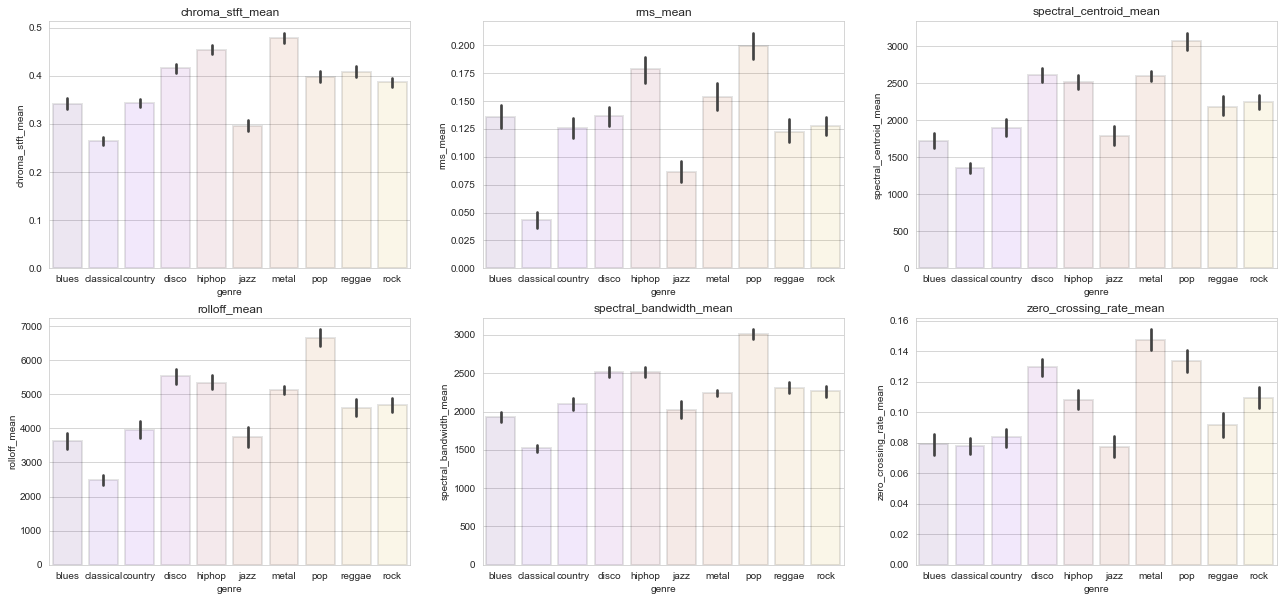

In [13]:
fig,axes = plt.subplots(2,3,figsize=(22,10))

feature = 0
for ax in axes:
    for subax in ax:
        sns.barplot(data=dataset,y = interesting_columns[feature],x = 'label',palette='gnuplot',ax=subax, alpha=.1, linewidth=2, edgecolor="0")
        subax.set(xlabel="genre",title=interesting_columns[feature])
        feature+=1
    

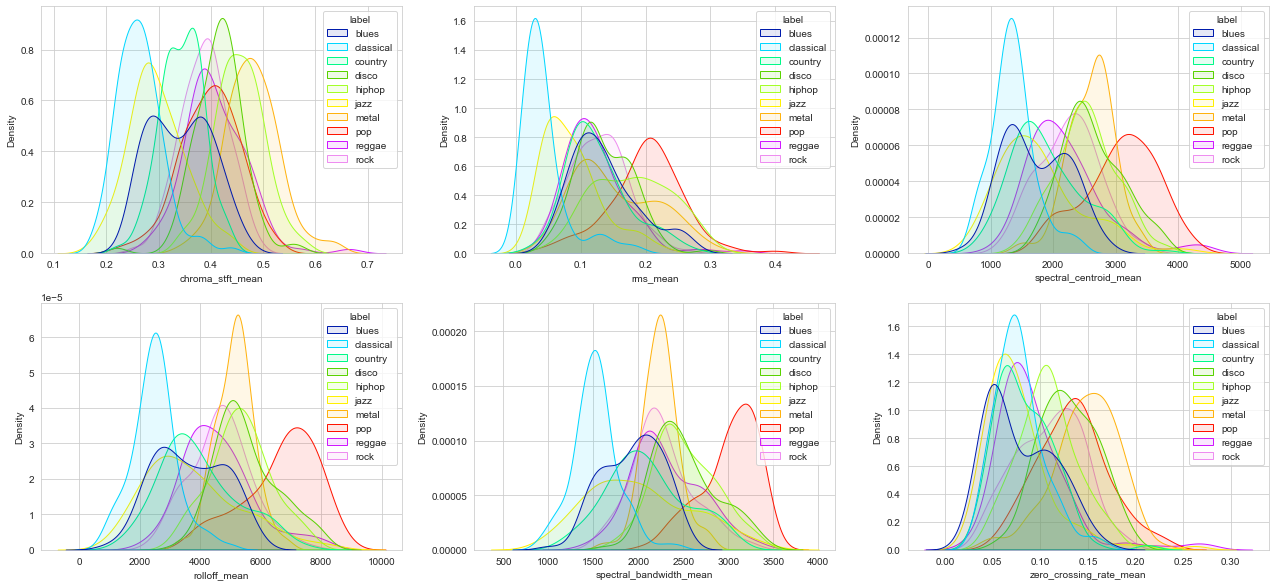

In [14]:
fig,axes = plt.subplots(2,3,figsize=(22,10))

feature = 0
for ax in axes:
    for subax in ax:
        sns.kdeplot(data=dataset,x = interesting_columns[feature],hue = 'label',palette='gist_ncar',ax=subax, linewidth=1, alpha=.1, fill=True)
        feature+=1
    

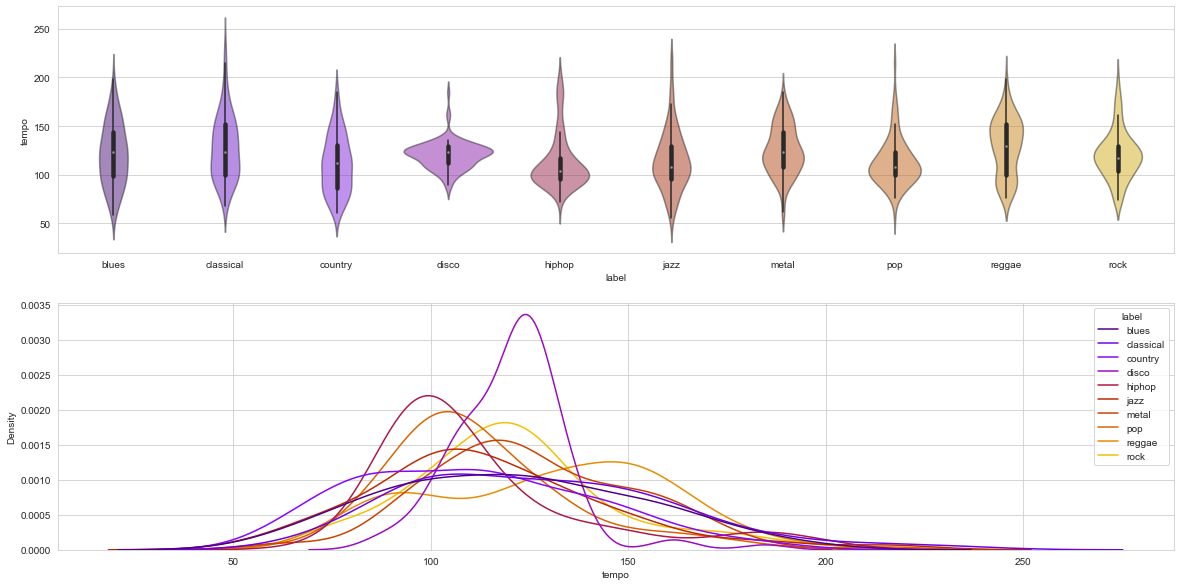

In [15]:
fig,ax=plt.subplots(2,1,figsize=(20,10))
sns.kdeplot(data=dataset,x='tempo',hue='label',palette='gnuplot',ax=ax[1])
sns.violinplot(data=dataset,y='tempo',x='label',palette='gnuplot',ax=ax[0])

for violin, alpha in zip(ax[0].collections[::1], [0.5]*20):
    violin.set_alpha(alpha)

Though this is not the main goal of this section, some remarks can be made about the previous visalizations : 

- Some genres are very distinct by their characteristics: Classical, for instance presents distinct rolloff-mean, rms-mean, spectral centroid and bandwidth mean. This could be due to the various instruments more present in classical (less more low-end, explaining the lower spectral centroid and rolloff), or the mixing techniques which are different

- In terms of tempo, which is one of the most defining high-level features for music genres, disco is clearly around 120bpm, which it is known for, but no other genre is quite as distinct.

- pop has much higher energy levels due to what is commonly called the loudness wars, essentially mixing engineers are now flirting with platform loudness regulations because what is louder seems better-sounding. It's interesting that such a trend could be found here in this dataset

### Data pre-processing

#### Min-max scaling, one-hot encoding and label encoding

We use min-max scaling to constrain all the features to the same range of (0-1). this allows us to negate the problems linked with high feature values leading to exploding weights. Furthermore, we use label encoding for single-output models ground truth (SVM, K-means), and one-hot encoding for multi-output models (SVM, MLP)

In [16]:
features = dataset.drop(columns=['label'])
gt  = dataset.label

In [17]:
le = sklearn.preprocessing.LabelEncoder()
ohe = sklearn.preprocessing.LabelBinarizer()
y_labels = le.fit_transform(gt)
y_ohe = ohe.fit_transform(y_labels)

In [18]:
mms = sklearn.preprocessing.MinMaxScaler()
X = mms.fit_transform(features)
label_correspondence = { y_labels[k]:gt[k] for k in range(len(gt))}

#### Train-test-validation split

We use a 80-10-10 train-test-validation due to the low amount of data we have (1000 samples). We will also be validating our optimal model through K-fold cross validation later on.

In [19]:
X_train,X_test,y_train,y_test = train_test_val_split(X,y_labels,train_size=.8,stratify=y_labels)

### metrics

#### Multiclass classification metrics

The usual multiclass classification metrics are the following

- global accuracy
- macro-averaged precision, recall, f1 score
- confusion matrix

In our case, recall is the sub-metric which interests us the most, as it represents the percentage of the time the model is able to predict each class wheren presented with a positive sample for the class. Essentially, our use case makes us consider the optimal model to be one that does not overshoot but retrieves the correct genre often when presented with each genre, with oppiosition to precision, which minimises false predictions.

We use macro-averaged metrics as there is no class imbalance and thus the arithmetic mean of each metric does not need to take into account class imbalance, which micro-averaging is for. 

#### Single-class one vs all metrics

Once our optimal model is established, it is interesting to consider its performance on all of the classes individually by considering a binary classification problem. This is useful to identify classes where classification does not function optimally to devise preprocessing strategies for better results. 



### Testing some out-of-the-box models

In this section, we implement some basic classification algorithms from sklearn, out of the box. We use provided default values or values obtained by quick trial-and-error to establish a baseline for all models, and use k-fold validation to compute average accuracy, maximum accuracy, and minimum accuracy for each model.

This will allow us to isolate our top 3 models which we will then fine-tune to reach best accuracy values.

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "poly SVM",
    "Decision Tree",
    "Random Forest",
    "Naive Bayes",'logreg','MLP','Gradient Boosted'
]

KNN = KNeighborsClassifier(20)
LinSVM = SVC(kernel="linear", C=0.025)
rbfSVM = SVC(gamma=0.1, C=1)
polySVM = SVC(kernel="poly", C=0.005, degree = 5)
DT = DecisionTreeClassifier(max_depth=5,max_features='auto')
# RF = RandomForestClassifier(max_depth=10, n_estimators=400,max_features='auto')
RF = RandomForestClassifier(max_depth=10, n_estimators=500,max_features="auto",min_samples_leaf=20)
NB = GaussianNB()
Logreg = LogisticRegression(C=0.1)
NN = MLPClassifier((80,40),batch_size=100,alpha=0.04,max_iter=2000)
XGB = GradientBoostingClassifier(n_estimators=700,max_features='auto',learning_rate=0.1,subsample=0.5,min_samples_leaf=20)

out_of_the_box = [KNN, LinSVM, rbfSVM, polySVM, DT, RF, NB,Logreg, NN, XGB]

In [21]:
out_of_the_box_results = []

for classifier in out_of_the_box:
    classifier.fit(X_train,y_train)
    out_of_the_box_results.append(list(score_classifier(classifier,X_test,y_test)))

out_of_the_box_results = pd.DataFrame(out_of_the_box_results,columns = ['accuracy','precision','recall','f1'],index=names)

In [22]:
out_of_the_box_results.T

Nearest Neighbors  Linear SVM   RBF SVM  poly SVM  Decision Tree  \
accuracy            0.630000    0.440000  0.575000  0.635000       0.415000   
precision           0.630000    0.440000  0.575000  0.635000       0.415000   
recall              0.672472    0.470546  0.559929  0.641711       0.554673   
f1                  0.629397    0.402823  0.557495  0.630691       0.425063   

           Random Forest  Naive Bayes    logreg       MLP  Gradient Boosted  
accuracy        0.720000     0.525000  0.510000  0.755000          0.840000  
precision       0.720000     0.525000  0.510000  0.755000          0.840000  
recall          0.721985     0.533071  0.467771  0.761967          0.856169  
f1              0.714647     0.502177  0.457503  0.755188          0.844182

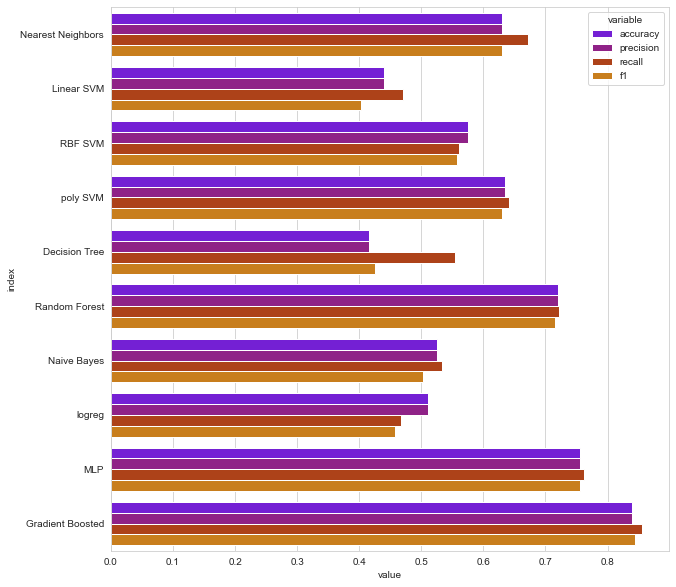

In [23]:
plotting_data = pd.melt(out_of_the_box_results.reset_index(),id_vars='index',value_vars=['accuracy','precision','recall','f1'])

fig,ax = plt.subplots(figsize=(10,10))
sns.barplot(data=plotting_data,y='index',hue='variable',x='value',palette='gnuplot')
display()

Three models come out on top: Gradient boosted algorithms,  with on average 83% accuracy, MLP with on average 77% and Random forest with 72% on average. We will be moving forward with these models to decide which one we will be choosing as our final model.

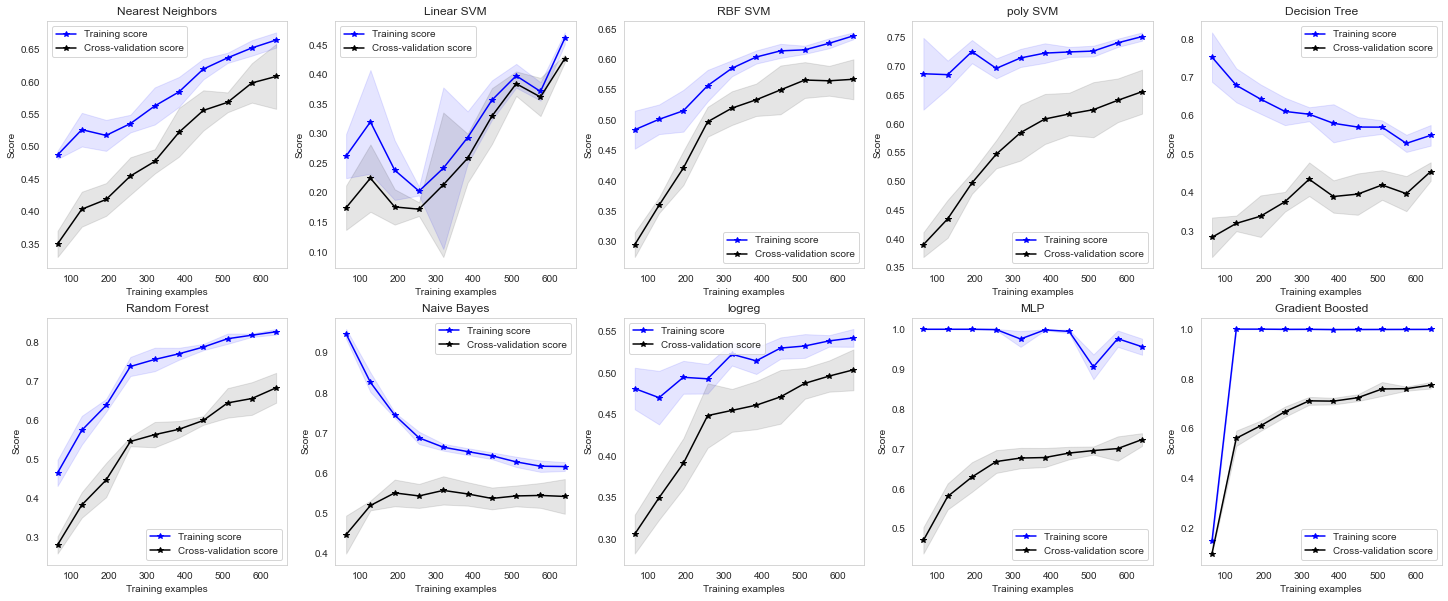

In [24]:

fig,axes = plt.subplots(2,5,figsize=(25,10))

classifier=0
for ax in axes:
    for subax in ax:
        plot_learning_curve(out_of_the_box[classifier],names[classifier],X_train,y_train,axes=subax,cv=5,n_jobs=10)
        classifier+=1
    

# plot_learning_curve(rbfSVM,'MLP classifier',X_train,y_train)

10-Fold cross validation reveals our top 3 optimal models. We rely not only on pure accuracy, but also recall, shown previously to be our metric of preference for this use case, explainability and customization capabilities. Our attention lands on these three models, which will now be submitted to a hyperparameter grid search to determine optimal hyperparameter values on the test set:

- XGBoost, for its high customization capabilities and features importance analysis possibilities
- MLP, for its high customization
- Random forest, for its explainability

and all of these models because they scored top 3 in terms of best accuracy with our test data validation. We establish the following grid search dictionaries for our selected models

In [25]:
MLP_grid = {

    'hidden_layer_sizes' : [(128),(64),(32),(64,64),(128,64),(256,64),(64,128,64),(32,64,32),(16,32,16)],
    'alpha': [0.0001,0.001,0.01,0.1,1],
    'learning_rate':['constant','adaptative'],
    'max_iter': [1000]
}

XGB_grid = {
    
    'learning_rate': [0.001,0.01,0.1],
    'n_estimators': [10,100,500],
    'subsample': [0.1,0.5,1],
    'min_samples_split' : [1,10,100],
    'min_samples_leaf': [1,10,40],
    'max_depth' : [5,10,50],
    'max_features' :[10,20,'auto'],
    
}

RF_grid = {
    'n_estimators' : [10,50,100,500],
    'max_depth' : [5,10,50,100],
    'min_samples_split': [2,5,10,50,100],
    'min_samples_leaf' : [2,5,10,50,100],    
    'max_features' :[3,10,20,'auto']
    
}

In [26]:
search_RF = False
if search_RF:
    RF_best = RandomForestClassifier()
    RF_grid_search = GridSearchCV(RF_best, RF_grid,verbose=1)
    RF_grid_search.fit(X_train,y_train)

In [27]:
search_BG = False
if search_BG:
    GB = GradientBoostingClassifier()
    GB_grid_search = GridSearchCV(GB, XGB_grid,verbose=1)
    GB_grid_search.fit(X_train,y_train)

In [28]:
search_MLP = False
if search_MLP:
    MLP = MLPClassifier()
    MLP_grid_search = GridSearchCV(MLP, MLP_grid,verbose=1)
    MLP_grid_search.fit(X_train,y_train)

In [29]:
import pickle

saveRF = False
saveGB = False
saveMLP = False
if saveRF:
    pickle.dump(RF_grid_search.best_estimator_,open('best_RF_estimator.sav','wb'))
if saveGB:
    pickle.dump(GB_grid_search.best_estimator_,open('best_GB_estimator.sav','wb'))
if saveMLP:
    pickle.dump(MLP_grid_search.best_estimator_,open('best_MLP_estimator.sav','wb'))

In [30]:
searched = False
if searched:
    best_RF = RF_grid_search.best_estimator_
    best_GB = GB_grid_search.best_estimator_
    best_MLP = MLP_grid_search.best_estimator_
else:
    best_RF = pickle.load(open('best_RF_estimator.sav','rb'))
    best_GB = pickle.load(open('best_GB_estimator.sav','rb'))
    best_MLP = pickle.load(open('best_MLP_estimator.sav','rb'))
    
best_classifiers = [best_RF,best_GB,best_MLP]
best_names = ['best random forest','best gradient boosted','best MLP']

In [31]:
best_results = []

for classifier in best_classifiers:
    classifier.fit(X_train,y_train)
    best_results.append(list(score_classifier(classifier,X_test,y_test)))

best_results = pd.DataFrame(best_results,columns = ['accuracy','precision','recall','f1'],index=best_names)

In [32]:
best_results

accuracy  precision    recall        f1
best random forest        0.805      0.805  0.806258  0.801517
best gradient boosted     0.840      0.840  0.852246  0.838124
best MLP                  0.755      0.755  0.775526  0.760170

On a macro-averaged metric standpoint, the best gradient boosted algorithm seems to beat out both others by a healthy 4 and 9 percent margin on accuracy. We will now look at single-class classification metrics to determine whether or not our best models seems to have any particular weaknesses in terms of classes.

In [44]:
microRF = pd.DataFrame(microscore_classifier(best_RF,X_test,y_test,'RF'),columns=list(label_correspondence.values()),index=['precision','recall','accuracy','model']).T
microGB = pd.DataFrame(microscore_classifier(best_GB,X_test,y_test,'GB'),columns=list(label_correspondence.values()),index=['precision','recall','accuracy','model']).T
microMLP = pd.DataFrame(microscore_classifier(best_MLP,X_test,y_test,'MLP'),columns=list(label_correspondence.values()),index=['precision','recall','accuracy','model']).T
all_micro = microRF.append(microGB).append(microMLP)

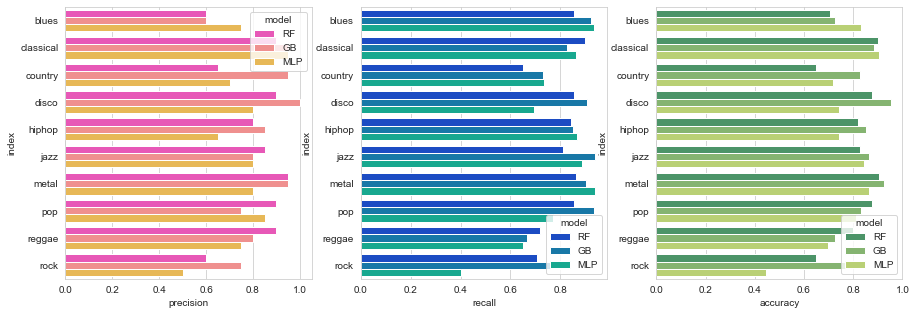

In [65]:
fig,ax = plt.subplots(1,3,figsize = (15,5))

sns.barplot(data = all_micro.reset_index(),x = 'precision',y='index',hue='model',ax=ax[0],palette='spring')

sns.barplot(data = all_micro.reset_index(),x = 'recall',y='index',hue='model',ax=ax[1],palette='winter')

sns.barplot(data = all_micro.reset_index(),x = 'accuracy',y='index',hue='model',ax=ax[2],palette='summer')
display()

There is not true observable discrepancy in terms of class metrics for all three models apart from three : Rock, Blues, and Country. This is not so surprising due to the similar natures of these music genres. On the other hand, all models perform well on classifical, jazz and disco, which, as we saw before, all present distinct feature differences compared to the other classes. If we now decide to visualize confusion matrixes on the test set for each model, this is what we get:

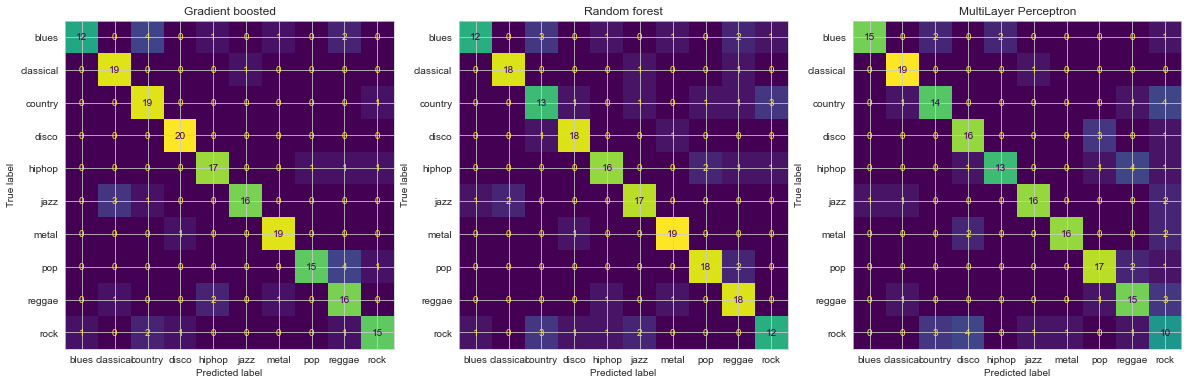

In [35]:
fig,ax= plt.subplots(1,3,figsize=(20,20))
plot_confusion_matrix(best_GB,X_test,y_test,ax=ax[0],classes_dic=list(label_correspondence.values()))
ax[0].set(title='Gradient boosted')
plot_confusion_matrix(best_RF,X_test,y_test,ax=ax[1],classes_dic=list(label_correspondence.values()))
ax[1].set(title='Random forest')
plot_confusion_matrix(best_MLP,X_test,y_test,ax=ax[2],classes_dic=list(label_correspondence.values()))
ax[2].set(title='MultiLayer Perceptron')
display()

We can see that thankfully, not many samples are present outside of the diagonal. However, when they are, some are coherent misclassifications, one a human might even make:

- Blues and country are somewhat exchanged in the gradient boosted algorithm predictions, which makes sense when compared in terms of musical influences and timelines
- Same thing for country and rock for the random forest classifier
- the MLP classifier presents some stranger misclassifications, like disco as rock for instance, but some coherent such as rock misclassified as country

Overall, there is no real trend for any given class to be misclassified apart from rock-blues-country samples, which, due to the similarities of the styles, is coherent. Additional pre-processing should be set up for these genres to further distinguish them.

## Explainability and feature importance

In [36]:
feature_importance_GB = best_GB.feature_importances_
feature_importance_RF = best_RF.feature_importances_

In [37]:
feature_importances = pd.DataFrame(np.transpose([feature_importance_GB,feature_importance_RF,features.columns]),columns=['GB','RF','feature'])

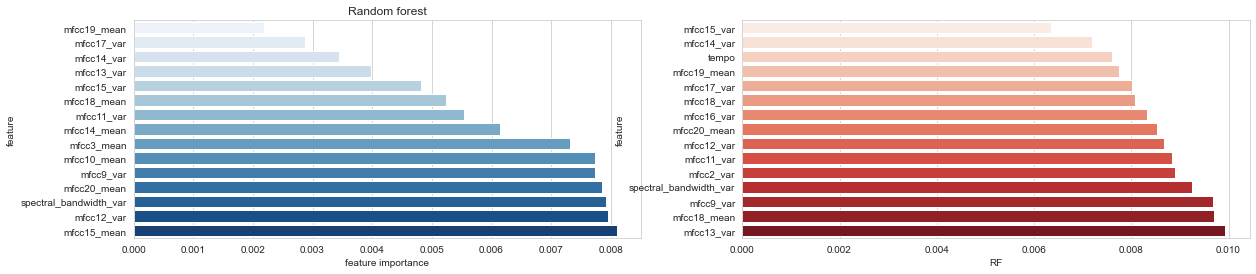

In [38]:
fig,ax = plt.subplots(1,2,figsize=(20,4))
sns.barplot(data=feature_importances.sort_values('GB').head(15),x='GB',y='feature',ax=ax[0],palette='Blues')
ax[0].set(title="Gradient Boosted",xlabel='feature importance',ylabel='feature')
sns.barplot(data=feature_importances.sort_values('RF').head(15),x='RF',y='feature',ax=ax[1],palette='Reds')
ax[0].set(title="Random forest",xlabel='feature importance',ylabel='feature')
display()

Contrary to 

Explainability for The gradient boosted algorithm and Random forest is rather easy to obtain. These are not black box models in which the decision process is left to guess for the user. We easily visualize a single decision tree from the 500 of the optimal model for both random forest and Gradient Boost below:

The goal here is not to visualize the best tree, but rather show the potential for explainability that random forest and gradient boosted algorithms compared to the somewhat black-box MLP model


In [63]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(best_GB.estimators_[0][9], X_test, y_test,
                target_name="genre",
                feature_names=features.columns,
              class_names = list(label_correspondence.values()))

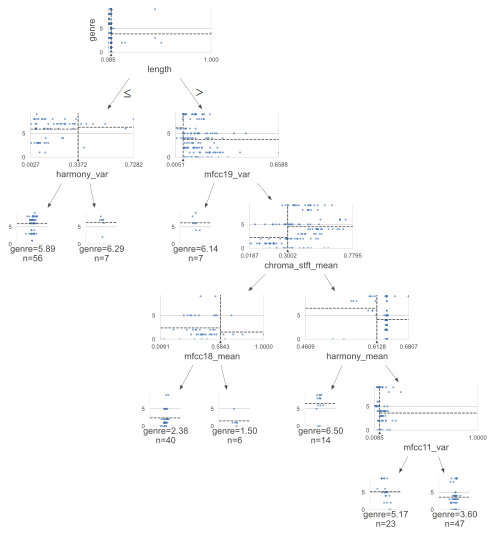

In [64]:
viz

In [41]:

viz = dtreeviz(best_RF.estimators_[0], X_test, y_test,
                target_name="genre",
                feature_names=features.columns,
              class_names = list(label_correspondence.values()))

In [42]:
viz

### Final Model

So, based on K-fold verified accuracy and recall, and due to the high explainability of the model, our model of choice is the best Gradient Boosted algorithm found by the grid search, reaching 84% accuracy on our test set. It goes without saying that more complex models could be trained outside of the context of this technical test: for instance, a custom MLP with dropout layers and further grid search could probably reach about 90% accuracy, as shown in this paper: 

https://biblio.ugent.be/publication/5973853


But with the resources available for this 1-Week study, the obtained accuracy is reasonable with regards to state of the art models. As previewed in part 2, further analysis could be done with harmonic-to-percussive ratios, keys, or even computer vision algorithms applied to the generated spectrograms. It would be interesting to explore these directions with a more voluminous and real-world dataset in the future.

# Thank you for your time! If you have any questions, please email me.

In [43]:
print(f'time to run whole notebook : {time.time()-t0}s')

time to run whole notebook : 225.76110219955444s


### To-do

- Comment EDA
- Comment training
- Comment Matrices
- Comment explainability
- Build custom MLP with keras/torch
- Training curves for MLP
- compare
- compare with SOTA